# 👩‍💻 개인 프로젝트(기여도 100%)

## 💡신노년세대 유형별 건강증진 전략이 어떻게 달라야 하는지 분석
## 💡복지 정책 및 스포츠 산업을 위한 마케팅 전략 제시

# 1. 배경

<img src="./newold.png" width="80%" align="left"></img><br/>

# 2. 활용 데이터 - 국민생활체육조사(2019)

- 국민들의 생활체육 참여 실태와 요구에 대한 설문조사 내용
- 우리나라 국민 9,000명을 대상으로 수집
- 지역별, 도시규모별, 성별, 연령별, 학력별, 직업별, 소득별 자료 함께 제공
- 코로나19의 영향을 배제하기 위해 2019년 자료 사용

# 3. 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette('husl'))                     # 그래프 컬러 지정
from survey import survey                                      # 설문조사 결과 시각화 함수
import cv2

from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from visualize import visualize_silhouette

import warnings
warnings.filterwarnings('ignore')

# 4. 데이터 전처리

In [2]:
# 설문조사 데이터 불러오기

df = pd.read_csv('./data/국민생활체육조사_2019.csv', header=1, low_memory=False)
df.head(2)

,ID,조사구번호,시도,동읍면부,시군구,읍면동,HTYPE,SEX,BIRTH,AGE,...,FAM,FAM_ETC,CHI,INC,IINC,JOB,JOB11,JOB12,JOB12_ETC,WT
0,1,11200682571,01. 서울특별시,1. 동부,동작구,대방동,1,1,200205,17,...,3,#NULL!,1,490,9,2,#NULL!,2,NaN,6833.2
1,2,11240641641,01. 서울특별시,1. 동부,송파구,삼전동,1,1,200209,17,...,4,#NULL!,1,500,10,2,#NULL!,2,NaN,6833.2


In [3]:
# 체육시설 데이터 불러오기

facility = pd.read_csv('./data/facility.csv')
facility.head()

,코드값,구분,코드명
0,101,공공체육시설,골프연습장
1,102,공공체육시설,하키장
2,103,공공체육시설,국궁장
3,104,공공체육시설,당구장
4,105,공공체육시설,롤러스케이트장


In [4]:
# 체육종목 데이터 불러오기

sports = pd.read_csv('./data/sports.csv')
sports.head()

,코드값,코드명
0,101,게이트볼
1,102,골프
2,103,농구
3,104,배구
4,105,"럭비, 미식축구"


In [5]:
# 중복 제거

df = df.drop_duplicates()

In [6]:
# 문자열 '#NULL!' --> NaN으로 치환

df = df.replace('#NULL!', np.nan)
df.head(2)

,ID,조사구번호,시도,동읍면부,시군구,읍면동,HTYPE,SEX,BIRTH,AGE,...,FAM,FAM_ETC,CHI,INC,IINC,JOB,JOB11,JOB12,JOB12_ETC,WT
0,1,11200682571,01. 서울특별시,1. 동부,동작구,대방동,1,1,200205,17,...,3,NaN,1,490,9,2,NaN,2,NaN,6833.2
1,2,11240641641,01. 서울특별시,1. 동부,송파구,삼전동,1,1,200209,17,...,4,NaN,1,500,10,2,NaN,2,NaN,6833.2


In [7]:
# 신노년세대 추출 --> 2019년 기준 1955 ~ 1963년생 --> 56 ~ 64세

df = df[(df['AGE'] >= 56) & (df['AGE'] <= 64)]
df = df.reset_index(drop=True)

In [8]:
# 데이터 개수 확인 --> 1305개

df.shape

(1305, 225)

# 5. 신노년세대 유형화
### <4가지 설문조사 문항 활용>


- 귀하의 가구원 전체의 월 평균 소득은 어느 정도입니까? --> 000만원
- 귀하의 체력상태는 현재 어느 정도라고 생각하십니까? --> ①전혀 좋지 않다 - ②별로 좋지 않다 - ③그저 그렇다 - ④좋다 - ⑤매우 좋다
- 귀하의 건강상태는 현재 어느 정도라고 생각하십니까? --> ①전혀 좋지 않다 - ②별로 좋지 않다 - ③그저 그렇다 - ④좋다 - ⑤매우 좋다
- 건강 및 체력을 유지하기 위해 규칙적인 체육활동을 얼마나 잘 수행하고 계십니까? --> ①전혀 수행하지 않는다 - ②별로 수행하지 않는다 - ③보통이다 - ④잘 수행한다 - ⑤매우 잘 수행한다

## (1) EDA

In [9]:
# 필요한 컬럼만 추출하여 df 생성 및 컬럼명 변경
# INC: 월평균가구소득 --> Income
# Q01: 본인의 건강상태에 대한 인식 --> Health
# Q03: 본인의 체력상태에 대한 인식 --> Strength
# Q051: 건강 및 체력 유지를 위한 방법 수행 정도 (규칙적인 체육활동) --> Exercise

Cluster = df[['ID', 'INC', 'Q01', 'Q03', 'Q051']]
Cluster = Cluster.rename(columns={'INC': 'Income', 'Q01': 'Health','Q03':'Strength', 'Q051':'Exercise'})
Cluster.head(2)

,ID,Income,Health,Strength,Exercise
0,389,280,4,4,2
1,390,530,3,2,2


In [10]:
# 결측치 확인 --> 없음

Cluster.isna().sum()

ID          0
Income      0
Health      0
Strength    0
Exercise    0
dtype: int64

In [11]:
# 전체 변수 EDA

Cluster.iloc[:, 1:].describe()

,Income,Health,Strength,Exercise
count,1305.000000,1305.000000,1305.000000,1305.000000
mean,374.226054,3.601533,3.473563,3.232950
std,154.603734,0.751684,0.763095,0.937127
min,30.000000,1.000000,1.000000,1.000000
25%,260.000000,3.000000,3.000000,3.000000
50%,360.000000,4.000000,4.000000,3.000000
75%,470.000000,4.000000,4.000000,4.000000
max,1300.000000,5.000000,5.000000,5.000000


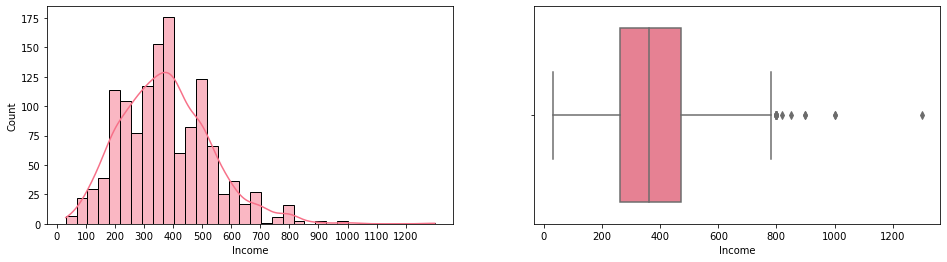

In [12]:
# 소득 분포 확인 --> 평균 374만원이며 오른꼬리가 긴 정규분포

plt.figure(figsize=(16, 4))
plt.subplot(1, 2, 1)
sns.histplot(data=Cluster, x='Income', kde=True)
plt.xticks(np.arange(0, 1300, 100))
plt.subplot(1, 2, 2)
sns.boxplot(data=Cluster, x='Income')
plt.show()

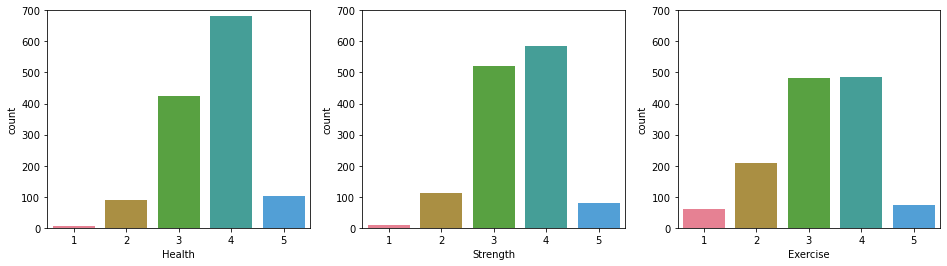

In [13]:
# 건강인식, 체력인식, 체육활동 분포 확인

features = ['Health', 'Strength', 'Exercise']
plt.figure(figsize=(16, 4))
for i, feature in enumerate(features):
    plt.subplot(1, 3, i+1)
    plt.ylim((0, 700))
    sns.countplot(data=Cluster, x=feature)
plt.show()

## (2) Kmeans Clustering

- 비계층적 군집분석 알고리즘
- 군집 내 데이터와 군집중심간의 거리를 최소화하는 k개의 군집으로 구분
- 계층적 방식에 비하여 계산량이 적고 대용량 데이터를 빠르게 처리

In [14]:
# 데이터 표준화, 정규화

std = StandardScaler()
X_std = std.fit_transform(Cluster.iloc[:, 1:])
X = normalize(X_std)

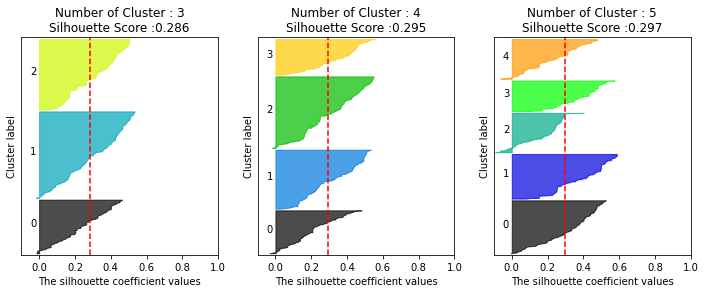

In [15]:
# 적정 군집수를 도출하기 위한 실루엣계수 확인
# 실루엣계수 전체 평균이 높으면서도 각 군집간 평균 차이가 크지 않은 4개 선택

visualize_silhouette([3, 4, 5], X)

In [16]:
# 군집수 4개로 K-Means 군집분석 실행

km = KMeans(n_clusters = 4,         # 군집수
            init = 'random',        # 초기 중심 좌표 설정 방법
            n_init = 10,            # 초기 중심위치 시도 횟수
            max_iter = 300,         # 최대 반복 횟수
            tol = 1e-04,            # 허용 오차값
            random_state=0)

km.fit(X)

KMeans(init='random', n_clusters=4, random_state=0)

In [17]:
# df에 군집번호 붙이기

Cluster['cluster'] = km.labels_

## (3) 군집별 EDA

In [18]:
Cluster.iloc[:, 1:].groupby('cluster').describe().T

cluster                   0           1           2           3
Income   count   268.000000  368.000000  447.000000  222.000000
         mean    585.988806  332.309783  299.116331  339.301802
         std     115.402130  104.082689  113.432246  105.102122
         min     400.000000   50.000000   30.000000   30.000000
         25%     500.000000  250.000000  200.000000  250.000000
         50%     550.000000  340.000000  300.000000  350.000000
         75%     650.000000  400.000000  380.000000  400.000000
         max    1300.000000  600.000000  750.000000  600.000000
Health   count   268.000000  368.000000  447.000000  222.000000
         mean      3.593284    4.076087    2.986577    4.063063
         std       0.521694    0.561890    0.672855    0.461735
         min       2.000000    2.000000    1.000000    3.000000
         25%       3.000000    4.000000    3.000000    4.000000
         50%       4.000000    4.000000    3.000000    4.000000
         75%       4.000000    4.000000    3.000000    4.000000
         max       5.000000    5.000000    4.000000    5.000000
Strength count   268.000000  368.000000  447.000000  222.000000
         mean      3.492537    3.986413    2.738255    4.081081
         std       0.564177    0.564461    0.497473    0.346544
         min       2.000000    3.000000    1.000000    3.000000
         25%       3.000000    4.000000    2.000000    4.000000
         50%       4.000000    4.000000    3.000000    4.000000
         75%       4.000000    4.000000    3.000000    4.000000
         max       5.000000    5.000000    4.000000    5.000000
Exercise count   268.000000  368.000000  447.000000  222.000000
         mean      3.268657    4.179348    2.812081    2.468468
         std       0.761077    0.384166    0.809438    0.690201
         min       1.000000    4.000000    1.000000    1.000000
         25%       3.000000    4.000000    2.000000    2.000000
         50%       3.000000    4.000000    3.000000    3.000000
         75%       4.000000    4.000000    3.000000    3.000000
         max       5.000000    5.000000    5.000000    3.000000

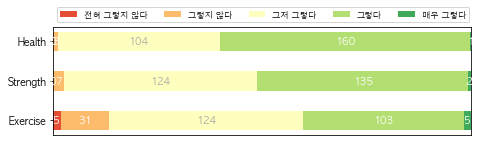

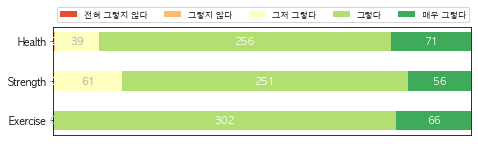

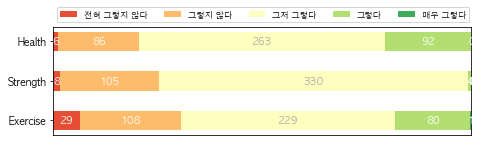

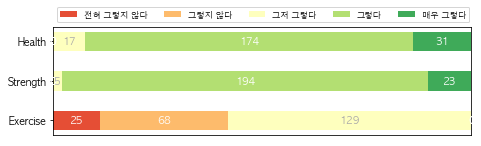

In [19]:
# 군집별 건강인식, 체력인식, 체육활동 분포 시각화

features = ['Health', 'Strength', 'Exercise']
category_names = ['전혀 그렇지 않다', '그렇지 않다', '그저 그렇다', '그렇다', '매우 그렇다']

for i in range(4):
    cluster = Cluster[Cluster['cluster'] == i]
    results = {}
    for feature in features:
        data = cluster.groupby(feature)[feature].count()
        lst = []
        for j in range(1, 6):
            try:
                lst.append(data[j])
            except:
                lst.append(0)
        results[feature] = lst
    survey(results, category_names)
plt.show()

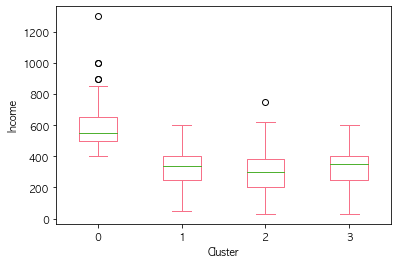

In [20]:
# 군집별 소득 박스플롯

Cluster.pivot(['ID'], 'cluster', 'Income').plot.box()
plt.xlabel('Cluster')
plt.ylabel('Income')
plt.show()

In [21]:
# df에 cluster 컬럼 추가

df = pd.merge(df, Cluster.iloc[:, [0, -1]], left_on='ID', right_on='ID')
df.head(2)

,ID,조사구번호,시도,동읍면부,시군구,읍면동,HTYPE,SEX,BIRTH,AGE,...,FAM_ETC,CHI,INC,IINC,JOB,JOB11,JOB12,JOB12_ETC,WT,cluster
0,389,11240642311,01. 서울특별시,1. 동부,송파구,삼전동,1,1,196201,57,...,NaN,2,280,5,1,7,NaN,NaN,9231.01,3
1,390,1121063090A,01. 서울특별시,1. 동부,관악구,남현동,2,1,196308,56,...,NaN,2,530,10,1,3,NaN,NaN,9231.01,2


In [22]:
# 군집별 df 생성

df0 = df[df['cluster'] == 0]
df1 = df[df['cluster'] == 1]
df2 = df[df['cluster'] == 2]
df3 = df[df['cluster'] == 3]

# 6. 유형0 집중 분석

### <체육활동 참여를 저해하는 요인>
### (1) 접근성 및 정보 부족
    체육활동 참여에 대한 의지는 있으나 니즈에 맞는 서비스가 없어서 & 정보가 없어서 참여하지 못하고 있는 것으로 보여짐
- 관심있는 프로그램 부재, 정보 부족, 마땅한 시설이 없어서 참여를 못한다는 답변
- 야외운동기구 및 공공시설 헬스장 등 전문적이지 않은 시설 이용중
- 헬스, 골프, 수영 등 대체로 일반적인 종목만 참여
- 정보 수집을 대중매체, 지인, 홍보물에 의존하며 인터넷 사용 비율 낮음
### ⇒ 보다 다양하고 전문적인 시설과 프로그램을 제공하여 참여를 유도

### (2) 시간적 여유 부족
- 직업이 있는 인원이 82.46%. 직장생활로 체육활동에 참여할 시간이 없는 것으로 보여짐
- 고소득 집단으로 은퇴 후 경제력을 기반으로 활발한 활동을 할 것으로 예상됨
### ⇒ 은퇴 후에 제공할 서비스 미리 준비

### <고급화 전략>
    비용 부족에 대한 응답이 없는 것은 아니나 10~20%로 높지 않음 → 고급화 전략 가능
- 골프 참여자 23.75%로 높은편. 고급 스포츠에 대한 부담감이 적을 것으로 예상
- 현재 사용하고 있는 전문적이지 않은 공공시설이 아닌 전문적인 프로그램 & 프라이빗 시설 제공
- 현재 체력상태가 (중)이므로 (상)으로 향상할 수 있는 전문 프로그램 제공
### ⇒ 단순 체력 관리가 아닌 라이프스타일을 향상할 수 있는 고급 건강증진 서비스 제공

In [23]:
# 체력관리 서비스를 이용하지 않는 이유
# --> 1. 체력관리 방법에 대한 정보가 없거나, 지식이 없어서 못하고 있다
# --> 3. 체력관리 방법을 알고 있으나, 마땅한 상담과 관리를 받을 만한 시설이나 프로그램이 없어서
# --> 2. 체력관리 방법을 알고 있으나, 비용이 많이 들어 못하고 있다

result = df0['Q1221'].value_counts()
for column in df0.loc[:, 'Q1222': 'Q1224']:
    result = result.add(df0[column].value_counts(), fill_value=0)
result / result.sum() * 100

1    46.363636
3    30.454545
2    21.818182
5     0.909091
7     0.454545
dtype: float64

In [24]:
# 자주 이용하는 체육시설 유형

result = df0['Q08101'].value_counts()
for column in df0.loc[:, 'Q08102': 'Q08110']:
    result = result.add(df0[column].value_counts(), fill_value=0)
result = result.reset_index().rename(columns={0: 'count'}).astype({'index': 'int'})
pd.merge(result, facility, left_on='index', right_on='코드값').sort_values('count', ascending=False)

,index,count,코드값,구분,코드명
8,118,37.0,118,공공체육시설,간이운동장(야외운동기구)
24,503,34.0,503,기타체육시설,공공주택단지 체육시설(아파트 등)
7,117,34.0,117,공공체육시설,체력단련장
10,301,22.0,301,민간체육시설,골프연습장
11,302,16.0,302,민간체육시설,골프장
20,323,13.0,323,민간체육시설,스크린골프장
16,317,13.0,317,민간체육시설,체력단련장
3,110,9.0,110,공공체육시설,수영장
15,311,9.0,311,민간체육시설,수영장
23,502,8.0,502,기타체육시설,"복지시설(노인복지시설, 노인대학, 경로당, 장애인시설,"


In [25]:
# 생활체육 강좌 경험 종목

result = df0['Q1111'].value_counts()
for column in df0.loc[:, 'Q1112': 'Q1113']:
    result = result.add(df0[column].value_counts(), fill_value=0)
result = result.reset_index().rename(columns={0: 'count'}).astype({'index': 'int'})
pd.merge(result, sports, left_on='index', right_on='코드값').sort_values('count', ascending=False)

,index,count,코드값,코드명
10,405,28.0,405,수영
0,102,26.0,102,골프
9,404,20.0,404,보디빌딩
4,116,8.0,116,테니스
7,203,7.0,203,태권도
11,406,5.0,406,"아쿠아 로빅, 수중발레"
12,407,5.0,407,에어로빅
5,117,4.0,117,배드민턴
6,120,4.0,120,탁구
13,408,4.0,408,"요가, 필라테스 ,태보"


In [26]:
# 생활체육 관련 정보 수집 경로
# --> 1. 대중매체(신문, TV, 라디오 등) = 5. 가족과 지인 - 4. 체육시설/단체의 홍보 - 2. 인터넷 - 3. 지방자치단체의 홍보

result = df0['Q131'].value_counts()

for column in df0.loc[:, 'Q132': 'Q133']:
    df0[column] = df0[column].fillna(0).astype('int')
    result = result.add(df0[column].value_counts(), fill_value=0)
result.sort_values(ascending=False) / 804 * 100

1    25.621891
5    25.621891
4    16.293532
2    14.676617
3    10.696517
7     3.482587
0     2.487562
6     1.119403
dtype: float64

In [27]:
# 생활체육 강좌 경험이 없는 이유 --> 1. 시간적인 여유 부재 - 3. 관심있는 생활체육 프로그램 강습 부재 - 2. 금전적인 여유 부재 

df0['Q1131'].value_counts().add(df0['Q1132'].value_counts(), fill_value=0) / 177 * 100

1    59.322034
3    24.858757
2    11.864407
4     2.824859
6     1.129944
dtype: float64

In [28]:
# 체육활동 참여 증진을 위한 선행조건(참여자 & 비참여자)
# --> 1. 체육활동시간 증가 4. 체육시설 접근성 확대 5. 건강상태 개선 2. 소득수준 증가 3. 체육활동 지출비용 여유

result = df0['Q271'].value_counts()
for column in df0.loc[:, ['Q272', 'Q273', 'Q301', 'Q302', 'Q303']]:
    result = result.add(df0[column].value_counts(), fill_value=0)
result.sort_values(ascending=False) / 762 * 100

1     22.572178
4     16.404199
5     14.173228
2     11.417323
3     10.236220
10     7.086614
6      7.086614
9      5.249344
8      3.937008
7      1.837270
dtype: float64

# 7. 유형3 집중 분석

### <체육활동 참여를 저해하는 요인>
### (1) 직장생활로 인한 시간 부족
- 체육활동과 관련한 모든 문항에서 참여도가 가장 낮음. 건강상태가 좋지 않은 저소득층 유형2 보다도 낮음.
- 체육활동에 참여하지 않는 이유를 묻는 모든 문항에서 ‘시간 여유 부족’이 압도적으로 높음
- 직업이 있는 인원이 87.84%로 가장 많음. 직장생활로 체육활동에 참여할 시간이 없는 것으로 보여짐

### (2) 금전적 여유 부족
- 유형0도 직업이 있는 인원이 82.46%로 많지만, 채육활동 참여도는 유형3보다 훨씬 높음. 유형0은 고소득 집단이므로 상대적으로 여유가 있는 것으로 추정

### ⇒ 시간적, 금전적 여유가 부족하므로 가볍게 실천할 수 있는 생활밀착형 운동 프로그램 제안
- 현재는 시간적, 금전적 여유의 부재로 체육활동 참여를 유도하는 것은 어려울 것으로 보임. 부담 없이 가볍게 시작할 수 있는 간단한 활동부터 유도
- 은퇴 후에는 체육활동에 활발하게 참여할 수 있는 잠재 고객이므로 지금부터 지속적인 접근 필요

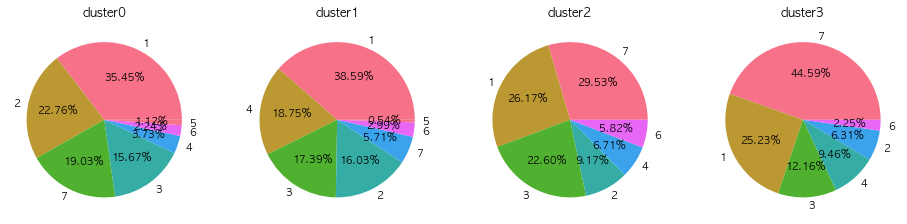

In [29]:
# 자주 이용하는 체육시설 유형 --> '7. 이용하지 않는다'의 비율이 가장 높음

DF = [df0, df1, df2, df3]
plt.figure(figsize=(16, 4))

for i, D in enumerate(DF):
    plt.subplot(1, 4, i+1)
    plt.title(f'cluster{i}')
    plt.pie(D['Q08'].value_counts(), labels=D['Q08'].value_counts().index, autopct='%.2f%%')
plt.show()

In [30]:
# 해당 체육시설을 자주 이용하지 않는 이유
# --> 2. 시간적 여유가 없어서 - 6. 체육시설에 대한 정보가 없어서
# --> 4. 체육시설이 전문적이지 않아서 - 5. 체육활동 프로그램이 다양하지 않아서 - 1. 거리가 멀어서

df3['Q083'].value_counts(normalize=True)

2    0.727273
6    0.080808
4    0.050505
5    0.050505
1    0.050505
3    0.040404
Name: Q083, dtype: float64

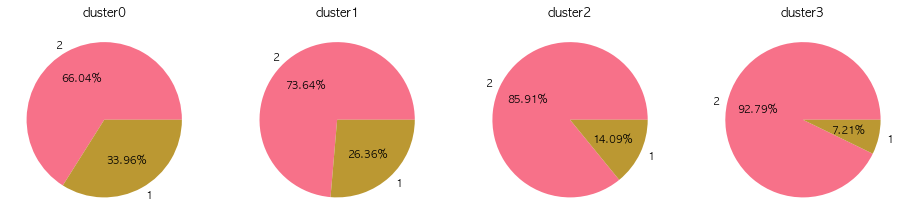

In [31]:
# 생활체육 관련 강좌, 강습 유무  --> '2. 없음'의 비율이 가장 높음

DF = [df0, df1, df2, df3]
plt.figure(figsize=(16, 4))

for i, D in enumerate(DF):
    plt.subplot(1, 4, i+1)
    plt.title(f'cluster{i}')
    plt.pie(D['Q11'].value_counts(), labels=[2, 1], autopct='%.2f%%')
plt.show()

In [32]:
# 생활체육 강좌, 강습 경험이 없는 이유
# --> 1. 시간적인 여유 부재 - 3. 관심있는 생활체육 프로그램 강습 부재 - 2. 금전적인 여유 부재 - 4. 생활체육 강습을 받을 만한 시설 부재

df3['Q1131'].value_counts().add(df3['Q1132'].value_counts(), fill_value=0) / 206 * 100

1    48.543689
3    24.271845
2    14.077670
4    13.106796
dtype: float64

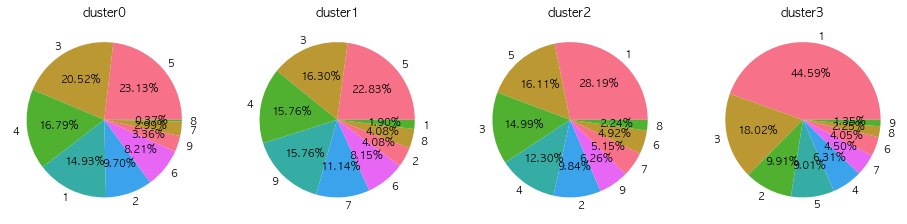

In [33]:
# 최근 1년간 규칙적 체육활동 참여 빈도  --> '1. 전혀하지 않는다'의 비율이 가장 높음

DF = [df0, df1, df2, df3]
plt.figure(figsize=(16, 4))

for i, D in enumerate(DF):
    plt.subplot(1, 4, i+1)
    plt.title(f'cluster{i}')
    plt.pie(D['Q16'].value_counts(), labels=D['Q16'].value_counts().index, autopct='%.2f%%')
plt.show()

In [34]:
# 규칙적으로 참여하지 않은 이유
# --> 1. 체육활동 가능시간 부족 - 9. 체육활동에 대한 관심 부족 - 4. 체육시설 접근성 낮음 - 7. 체육활동 정보 부족

result = df3['Q2911'].value_counts()
for column in df3.loc[:, ['Q2912', 'Q2913', 'Q2921', 'Q2922', 'Q2923']]:
    result = result.add(df3[column].value_counts(), fill_value=0)
result.sort_values(ascending=False) / 285 * 100

1     26.315789
9     18.596491
4     13.333333
7     10.175439
3      8.771930
10     5.614035
6      5.263158
11     4.561404
2      3.508772
8      2.105263
5      1.403509
19     0.350877
dtype: float64

In [35]:
# 체육활동 참여 증진을 위한 선행조건(참여자 & 비참여자)
# --> 1. 체육활동시간 증가 - 4. 체육시설 접근성 확대 - 3. 체육활동 지출비용 여유 - 2. 소득수준 증가 - 5. 건강상태 개선

result = df3['Q271'].value_counts()
for column in df3.loc[:, ['Q272', 'Q273', 'Q301', 'Q302', 'Q303']]:
    result = result.add(df3[column].value_counts(), fill_value=0)
result.sort_values(ascending=False) / 663 * 100

1     22.021116
4     15.987934
3     13.725490
2     10.558069
5     10.407240
10     6.938160
9      6.485671
6      6.033183
8      5.580694
7      2.262443
dtype: float64

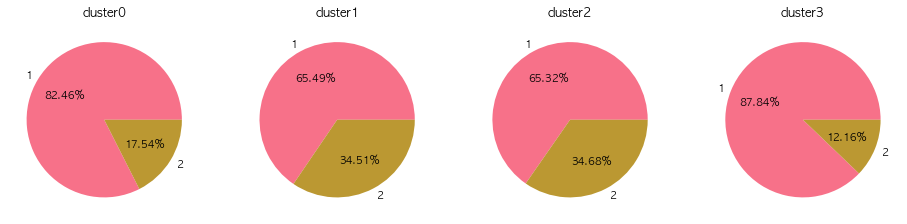

In [36]:
# 시간적 여유가 없는 이유가 뭘까? --> 직업을 가진 비율이 높음 & 비슷한 비율인 유형0 비해 소득이 높지 않아 여유가 더 없을 것으로 예상
# 유형별 직업 유무

DF = [df0, df1, df2, df3]
plt.figure(figsize=(16, 4))

for i, D in enumerate(DF):
    plt.subplot(1, 4, i+1)
    plt.title(f'cluster{i}')
    plt.pie(D['JOB'].value_counts(), labels=[1, 2], autopct='%.2f%%')
plt.show()

# 8. 한계점 및 느낀점
- 신노년세대가 아닌 전체 연령을 대상으로한 설문조사라서 데이터 개수가 적었으며 신노년세대의 특성을 완전하게 파악하기는 어려웠음
- 한정된 자료였지만 군집화가 잘 되었고 유형별 특성도 두드러지게 나타나서 분석을 잘 진행할 수 있었음

# 9. 참고 문헌
- 2022 고령자 통계(통계청, 2022)
- 현재 노인 인구 만한 730만 베이비부머···고령화 쓰나미 온다(중앙일보, 2020)
- 신노년세대를 위한 노인일자리 개편방안 연구(한국노인인력개발원, 2020)